In [186]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))

#### Load observed data for comparison

In [23]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCH*_1f.spec.fits'))

fluxes = []
wls = []
am = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    airmass = (hdr["AMSTART"] + hdr["AMEND"])/2
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
    am.append(airmass)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [24]:
# check if wl changes across orders
jj=1
pix=0
wls[:,jj,pix]

array([1.77544383, 1.77544383, 1.77544362, 1.77544362, 1.77544362,
       1.77544362, 1.77544362, 1.77544362, 1.77544341, 1.77544341,
       1.77544341, 1.77544341, 1.77544341, 1.77544341, 1.7754432 ,
       1.7754432 , 1.7754432 , 1.7754432 , 1.7754432 , 1.77544298,
       1.77544298, 1.77544298, 1.77544298, 1.77544298, 1.77544298,
       1.77544277, 1.77544277, 1.77544277, 1.77544277, 1.77544277,
       1.77544256, 1.77544256, 1.77544256, 1.77544256, 1.77544235,
       1.77544235, 1.77544235, 1.77544235, 1.77544235, 1.77544235,
       1.77544214, 1.77544214, 1.77544214, 1.77544214, 1.77544214,
       1.77544214, 1.77544193, 1.77544193, 1.77544193, 1.77544193,
       1.77544193, 1.77544193, 1.77544193, 1.77544193, 1.77544171,
       1.77544171])

#### Load H band results

In [187]:
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
modellist = []
for f in sorted(glob.glob("result/CIFIST/IGRINS_W1049B_H_chipmods_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    #chipmods[modelname] = np.median(chipmods[modelname], axis=0) # avg over 56 obs
    modellist.append(modelname)
for f in sorted(glob.glob("result/CIFIST/IGRINS_W1049B_H_chiplams_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
    #chiplams[modelname] = np.median(chiplams[modelname], axis=0) # avg over 56 obs
for f in sorted(glob.glob("result/CIFIST/IGRINS_W1049B_H_*-5.*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
chisq.keys()

dict_keys(['lte012.0-5.0', 'lte012.0-5.5', 'lte013.0-5.0', 'lte013.0-5.5', 'lte014.0-5.0', 'lte014.0-5.5', 'lte015.0-5.0', 'lte015.0-5.5', 'lte015.5-5.0', 'lte015.5-5.5', 'lte016.0-5.0', 'lte016.0-5.5', 'lte016.5-5.0', 'lte016.5-5.5', 'lte017.0-5.0', 'lte017.0-5.5', 'lte017.5-5.0', 'lte017.5-5.5', 'lte018.0-5.0', 'lte018.0-5.5', 'lte018.5-5.0', 'lte018.5-5.5', 'lte019.0-5.0', 'lte019.0-5.5', 'lte019.5-5.0', 'lte019.5-5.5'])

#### Plot $\chi^2$ vs orders and observations

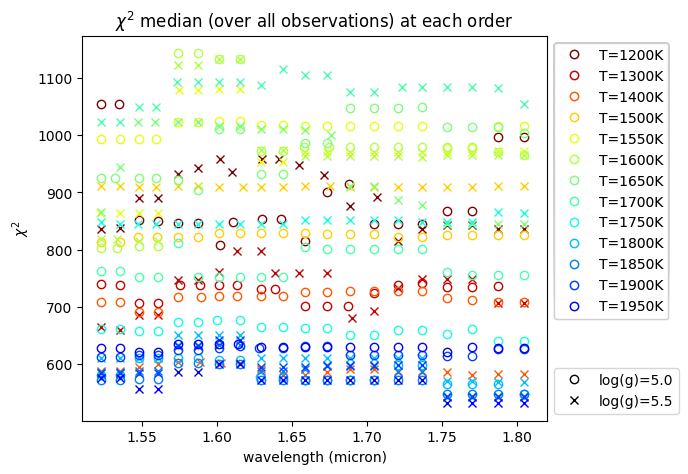

In [221]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.xlim((1.51, 1.82))
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

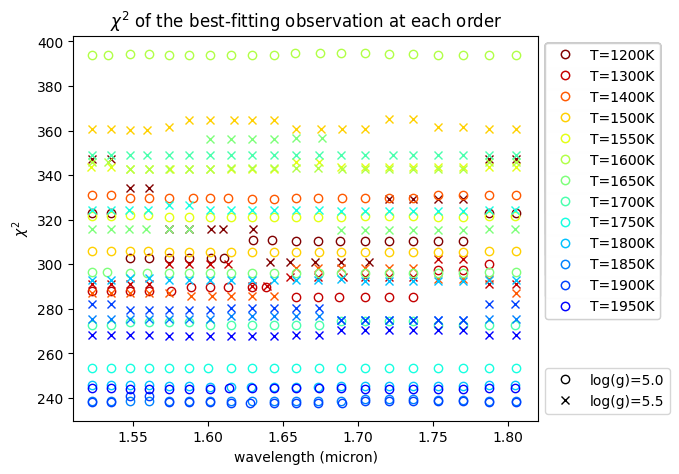

In [219]:
# chisq vs. order(wavelength), min of all observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.xlim((1.51, 1.82))
    plt.title("$\chi^2$ of the best-fitting observation at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

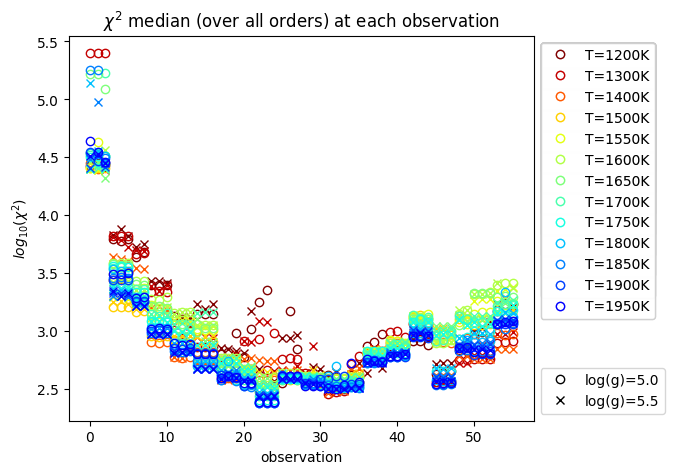

In [222]:
# chisq vs. observations, median over orders
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((56, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(56) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((56, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(56) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("observation")
    plt.ylabel("$log_{10}(\chi^2)$")
    plt.title("$\chi^2$ median (over all orders) at each observation")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

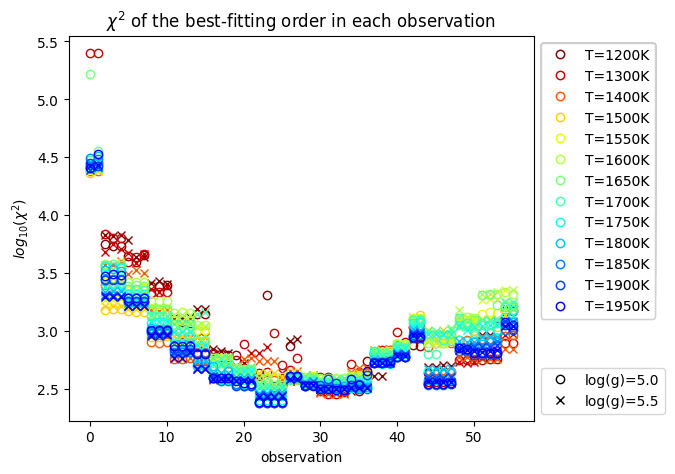

In [218]:
# chisq vs. observations, min of all orders
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(56) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(56) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("observation")
    plt.ylabel("$log_{10}(\chi^2)$")
    plt.title("$\chi^2$ of the best-fitting order in each observation")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

#### Plot best-fit parameters in each order and observation

In [235]:
modellist[0:1]

['lte012.0-5.0']

In [244]:
# find the best-fitting obs at each order
best_ind = {}
for model in modellist:
    chisq_this = np.array(chisq[model].reshape((56, 20)))
    min_chisqs = np.min(chisq_this, axis=0)
    best_ind[model] = (chisq_this==min_chisqs)

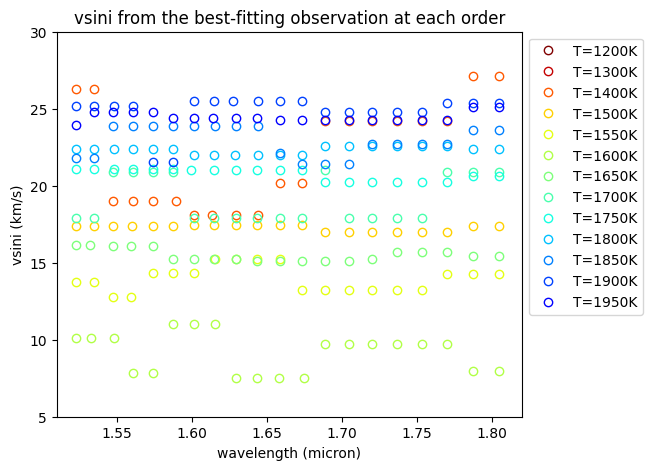

In [247]:
# fitted vsini vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((56, 20))[best_ind[model]]
        plt.plot(lam_points, vsini_points, "o", mfc="none", color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")


    plt.xlabel("wavelength (micron)")
    plt.ylabel("vsini (km/s)")
    plt.legend(loc=2, bbox_to_anchor=(1, 1))
    plt.xlim((1.51, 1.82))
    plt.ylim((5,30))
    plt.title("vsini from the best-fitting observation at each order")

#plt.ylim(10,60)

In [274]:
obs.shape

(56, 20)

Text(0.5, 1.0, 'fitted spectrum using model CIFIST lte019.0-5.0')

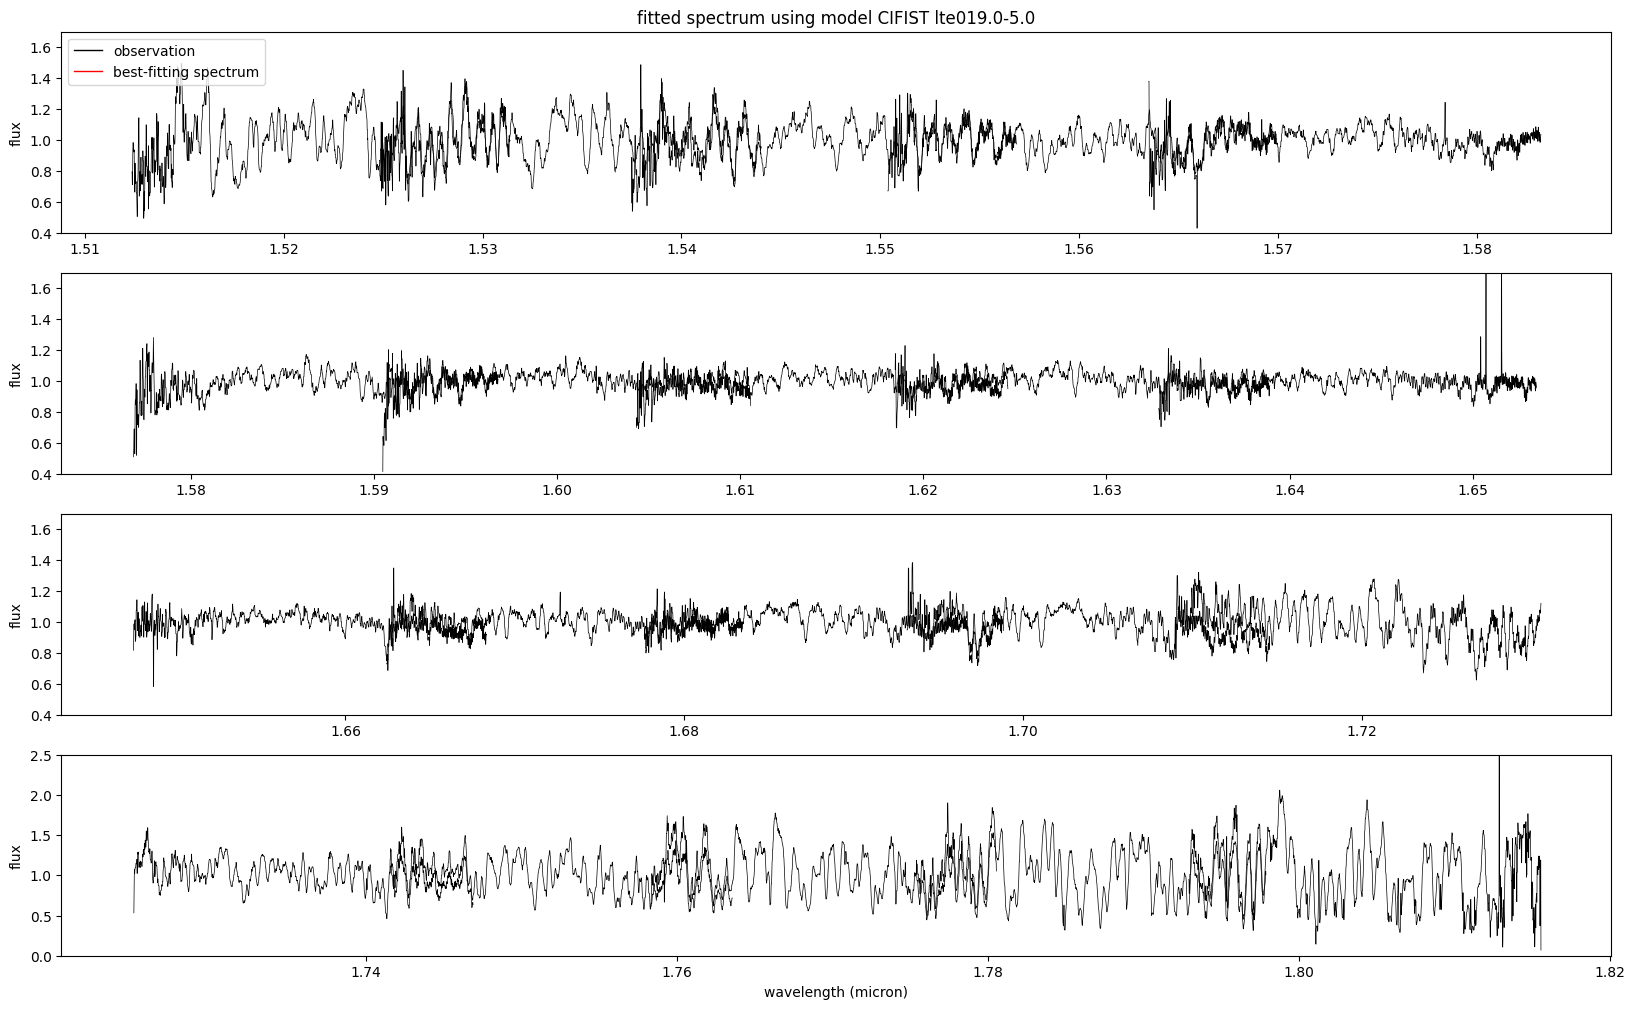

In [277]:
model = 'lte019.0-5.0'
obs = best_ind[model]
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][obs[:,jj], jj,:], chipmods[model][obs[:,jj], jj,:], linewidth=0.5, color="r", label="fitted")
        #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
    plt.ylabel("flux")
    if sub==0:
        plt.xlabel("wavelength (micron)")
        plt.ylim((0,2.5))
    else:
        plt.ylim((0.4,1.7))
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
                        #Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting spectrum"], loc=2)
plt.title(f"fitted spectrum using model CIFIST {model}")

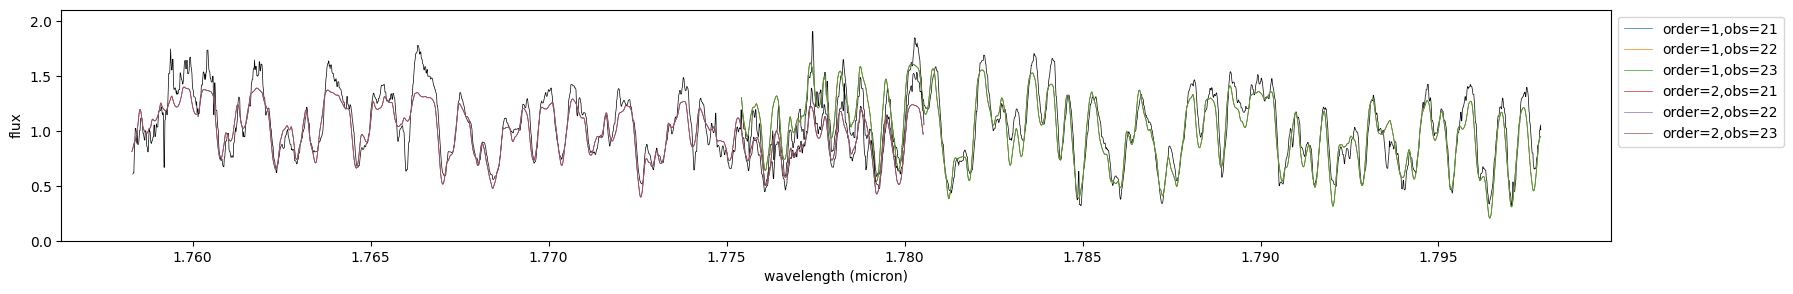

In [135]:
model = 'lte015.0-5.0'
obs = 23
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,3))
for jj in range(1,3):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black")
    for obs in range(21,24):
        plt.plot(chiplams[model][obs, jj,:], chipmods[model][obs, jj,:], linewidth=0.5, label=f"order={jj},obs={obs}")

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")
plt.ylim((0, 2.1))
chi2 = np.array(chisq[model].reshape((56, 20)))

Text(0.5, 1.0, 'fitted $\\chi^2$ at order 1')

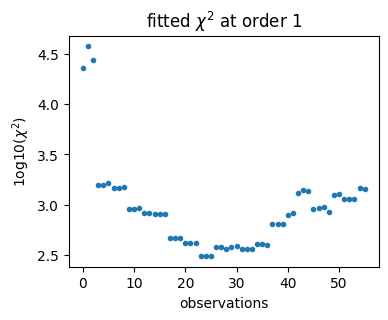

In [128]:
plt.figure(figsize=(4,3))
plt.plot(np.log10(chi2[:,1]), ".")
plt.ylabel("1og10($\chi^2$)")
plt.xlabel("observations")
plt.title("fitted $\chi^2$ at order 1")

In [72]:
chipmods1 = fits.getdata(f"result/CIFIST/IGRINS_W1049B_H_chipmods_lte013.0-5.0.fits")
chiplams1 = fits.getdata(f"result/CIFIST/IGRINS_W1049B_H_chiplams_lte013.0-5.0.fits")

In [73]:
chipmods2 = fits.getdata(f"result/CIFIST/IGRINS_W1049B_H_chipmods_lte015.0-5.0.fits")
chiplams2 = fits.getdata(f"result/CIFIST/IGRINS_W1049B_H_chiplams_lte015.0-5.0.fits")

Text(0, 0.5, 'flux')

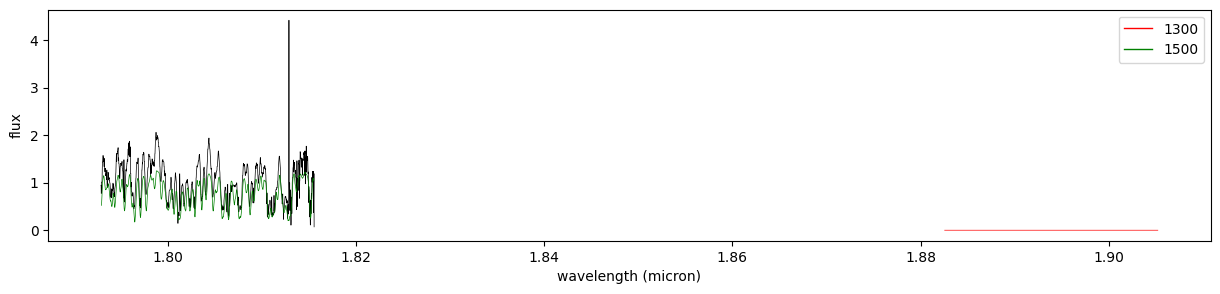

In [76]:
chipmods1_mean = np.median(chipmods1, axis=0)
chiplams1_mean = np.median(chiplams1, axis=0)
chipmods2_mean = np.median(chipmods2, axis=0)
chiplams2_mean = np.median(chiplams2, axis=0)
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(15,3))
for jj in range(1):
    plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
    plt.plot(chiplams1_mean[jj,:], chipmods1_mean[jj,:], linewidth=0.5, color="r")
    plt.plot(chiplams2_mean[jj,:], chipmods2_mean[jj,:], linewidth=0.5, color="g")
    #plt.plot(chiplams_mean[jj,:], chipmodnobroad_mean[jj,:], linewidth=0.1, color="g", label="fitted nobroad")
custom_lines = [Line2D([0], [0], color="r", lw=1),
                Line2D([0], [0], color="g", lw=1),]
                #Line2D([0], [0], color="g", lw=1),]
plt.legend(custom_lines, ["1300", "1500"])
plt.xlabel("wavelength (micron)")
plt.ylabel("flux")

In [13]:
new

array([[[0.8753065 , 0.90094699, 0.92618673, ..., 0.64588357,
         0.61797215, 0.59139475],
        [1.16785497, 1.11997346, 1.07683388, ..., 0.97768046,
         0.9977162 , 1.01584233],
        [0.80992557, 0.80892062, 0.81680475, ..., 0.99550145,
         0.97522796, 0.95894138],
        ...,
        [0.91552754, 0.90143137, 0.87680086, ..., 1.03799689,
         1.0412251 , 1.04416333],
        [0.83354472, 0.84592497, 0.86241663, ..., 0.99083315,
         0.98135061, 0.97345903],
        [1.10726288, 1.09510539, 1.08576211, ..., 0.95929108,
         0.97532839, 0.98407809]],

       [[0.8753065 , 0.90094699, 0.92618673, ..., 0.64588357,
         0.61797215, 0.59139475],
        [1.16785497, 1.11997346, 1.07683388, ..., 0.97768046,
         0.9977162 , 1.01584233],
        [0.80992557, 0.80892062, 0.81680475, ..., 0.99550145,
         0.97522796, 0.95894138],
        ...,
        [0.91552754, 0.90143137, 0.87680086, ..., 1.03799689,
         1.0412251 , 1.04416333],
        [0.8